In [ ]:
import pandas as pd
import numpy as np
import torch # Import torch at a higher level
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import unicodedata # Kept if you plan to use it later for more advanced text cleaning
import re # Kept for potential advanced text cleaning
from google.colab import drive
drive.mount('/content/drive')
from huggingface_hub import login

# --- Configuration ---
MODEL_NAME = "vinai/phobert-large"
OUTPUT_DIR = '/content/drive/MyDrive/ChongPha_Ver2/PhoBERT/OUTPUT'
LOGGING_DIR = '/content/drive/MyDrive/ChongPha_Ver2/PhoBERT/LOGGING'
DATASET_PATH = "/content/drive/MyDrive/ChongPha_Ver2/Dataset_ChongPha.csv"
login(token='YOUR_HF_TOKEN_HERE')

# Define labels and their mapping (ensure this order is consistent)
# This mapping will be used by the Dataset class and for the classification report
LABELS = ["PHAN_DONG", "KHONG_PHAN_DONG", "KHONG_LIEN_QUAN"]
LABEL_TO_ID = {label: i for i, label in enumerate(LABELS)}
ID_TO_LABEL = {i: label for i, label in enumerate(LABELS)}
NUM_LABELS = len(LABELS)

print(f"Loading tokenizer: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
ACTUAL_CLS_TOKEN = tokenizer.cls_token
ACTUAL_SEP_TOKEN = tokenizer.sep_token
print(f"Using CLS token: '{ACTUAL_CLS_TOKEN}', SEP token: '{ACTUAL_SEP_TOKEN}'")

Mounted at /content/drive
Loading tokenizer: vinai/phobert-large


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Using CLS token: '<s>', SEP token: '</s>'


In [ ]:
def load_and_prepare_data(file_path, cls_token, sep_token, combine_summary_comment=True):
    df = pd.read_csv(file_path)
    df.info()
    if combine_summary_comment:
        df['summary'] = df['summary'].astype(str).fillna('')
        df['comment_clean'] = df['comment_clean'].astype(str).fillna('')

        # Manually construct the full string with all special tokens
        df['text'] = f"{cls_token} " + df['summary'] + f" {sep_token} " + df['comment_clean'] + f" {sep_token}"
    else: # Fallback for single comment - add CLS and SEP
        df['comment_clean'] = df['comment_clean'].astype(str).fillna('') # Assuming 'comment' if not combining
        df['text'] = f"{cls_token} " + df['comment_clean'] + f" {sep_token}"

    df['label'] = df['label'].astype(str)
    # Assuming LABELS is defined globally for validationTrue
    unknown_labels = set(df['label']) - set(LABELS)
    if unknown_labels:
        raise ValueError(f"Unknown labels found in {file_path}: {unknown_labels}. Expected labels are: {LABELS}")
    return df['text'], df['label']
print("Loading data...")

try:
    # Unpack the tuple returned by load_and_prepare_data
    data_texts, data_labels_str = load_and_prepare_data(DATASET_PATH, cls_token=ACTUAL_CLS_TOKEN, sep_token=ACTUAL_SEP_TOKEN)

    train_texts, temp_texts, train_labels_str, temp_labels_str = train_test_split(
        data_texts,          # Features
        data_labels_str,     # Labels (original strings)
        test_size=0.2,       # 20% for temp_texts and temp_labels_str
        random_state=2025,     # For reproducibility
        stratify=data_labels_str # Ensures proportional distribution based on these labels
    )

    # --- Second Split: (Validation vs. Test from Temp) ---
    # Splitting the 30% temporary set into 50% validation and 50% test
    # (which is 15% of original for val, 15% of original for test)
    # We stratify based on 'temp_labels_str'.
    val_texts, test_texts, val_labels_str, test_labels_str = train_test_split(
        temp_texts,          # Features from the temporary set
        temp_labels_str,     # Labels from the temporary set (original strings)
        test_size=0.5,       # 50% of temp_texts for test_texts
        random_state=2025,     # For reproducibility
        stratify=temp_labels_str  # Ensures proportional distribution



    # train_texts, train_labels_str = load_and_prepare_data("/content/drive/MyDrive/Data/splits/train.csv",cls_token=ACTUAL_CLS_TOKEN, sep_token=ACTUAL_SEP_TOKEN)
    # val_texts, val_labels_str = load_and_prepare_data("/content/drive/MyDrive/Data/splits/val.csv",cls_token=ACTUAL_CLS_TOKEN, sep_token=ACTUAL_SEP_TOKEN)
    # test_texts, test_labels_str = load_and_prepare_data("/content/drive/MyDrive/Data/splits/val.csv",cls_token=ACTUAL_CLS_TOKEN, sep_token=ACTUAL_SEP_TOKEN)
    )

    print(f"Total examples: {len(data_texts)}")
    print(f"Train examples: {len(train_texts)}, Validation examples: {len(val_texts)}, Test examples: {len(test_texts)}")

    # --- Verification of Label Distribution ---
    print("\nOriginal dataset label distribution:")
    print(pd.Series(data_labels_str).value_counts(normalize=True).sort_index())

    print("\nTraining set label distribution:")
    print(pd.Series(train_labels_str).value_counts(normalize=True).sort_index())

    print("\nValidation set label distribution:")
    print(pd.Series(val_labels_str).value_counts(normalize=True).sort_index())

    print("\nTest set label distribution:")
    print(pd.Series(test_labels_str).value_counts(normalize=True).sort_index())
    print(f"Sample train text: {train_texts.iloc[0]}...") # Print a sample
    print(f"Sample train label: {train_labels_str.iloc[0]}")
    print(f"Unique labels in training data: {train_labels_str.unique()}")

except FileNotFoundError:
    print("Error: One or more data files not found. Please check file paths.")
    # Exiting or using dummy data if files are not present
    # For demonstration, let's assume the script should stop if data isn't found
    exit()
except ValueError as ve:
    print(ve)
    print("Yo, there are some errors")
    exit()

Loading data...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18912 entries, 0 to 18911
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   summary        18912 non-null  object
 1   comment_raw    18912 non-null  object
 2   label          18912 non-null  object
 3   comment_clean  18912 non-null  object
dtypes: object(4)
memory usage: 591.1+ KB
Total examples: 18912
Train examples: 15129, Validation examples: 1891, Test examples: 1892

Original dataset label distribution:
label
KHONG_LIEN_QUAN    0.528976
KHONG_PHAN_DONG    0.356599
PHAN_DONG          0.114425
Name: proportion, dtype: float64

Training set label distribution:
label
KHONG_LIEN_QUAN    0.528984
KHONG_PHAN_DONG    0.356600
PHAN_DONG          0.114416
Name: proportion, dtype: float64

Validation set label distribution:
label
KHONG_LIEN_QUAN    0.528821
KHONG_PHAN_DONG    0.356425
PHAN_DONG          0.114754
Name: proportion, dtype: float64

Test s

In [ ]:
# --- 2. Tokenization ---
MAX_LENGTH = 256  # Max sequence length for tokenizer

print("Tokenizing texts...")
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=MAX_LENGTH)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=MAX_LENGTH)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length=MAX_LENGTH)

Tokenizing texts...


In [ ]:
# --- 3. Custom Dataset ---
class CommentDataset(Dataset):
    def __init__(self, encodings, string_labels):
        self.encodings = encodings
        if hasattr(string_labels, 'tolist'): # Handles pandas Series
            self.string_labels = string_labels.tolist()
        else:
            self.string_labels = string_labels

        # Validate labels during initialization
        if not all(isinstance(label, str) for label in self.string_labels):
            raise ValueError("All labels must be strings.")
        if not all(label in LABEL_TO_ID for label in self.string_labels):
            unknown = set(self.string_labels) - set(LABEL_TO_ID.keys())
            raise ValueError(f"Unknown labels found: {unknown}. Known: {list(LABEL_TO_ID.keys())}")

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx], dtype=torch.long) for key, val in self.encodings.items()}
        label_str = self.string_labels[idx]
        item['labels'] = torch.tensor(LABEL_TO_ID[label_str], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.string_labels)

print("Creating datasets...")
if not train_texts.empty:
    train_dataset = CommentDataset(train_encodings, train_labels_str)
else:
    print("Train dataset is empty. Cannot create CommentDataset for training.")
    train_dataset = None

if not val_texts.empty:
    val_dataset = CommentDataset(val_encodings, val_labels_str)
else:
    print("Validation dataset is empty. Cannot create CommentDataset for validation.")
    val_dataset = None

if not test_texts.empty:
    test_dataset = CommentDataset(test_encodings, test_labels_str)
else:
    print("Test dataset is empty. Cannot create CommentDataset for testing.")
    test_dataset = None

Creating datasets...


In [ ]:
# Add this cell after your dataset creation
from collections import Counter
from sklearn.utils import resample
import pandas as pd

def oversample_minority_classes(texts, labels, target_ratio=0.8):
    """
    Oversample minority classes to achieve better balance.

    Args:
        texts: Text data (pandas Series)
        labels: Labels (pandas Series)
        target_ratio: Target ratio for minority class relative to majority class

    Returns:
        Balanced texts and labels
    """
    # Convert to DataFrame for easier manipulation
    df = pd.DataFrame({'text': texts, 'label': labels})

    # Count original distribution
    label_counts = Counter(labels)
    print("Original distribution:")
    for label, count in label_counts.items():
        print(f"  {label}: {count}")

    # Find majority class size
    majority_size = max(label_counts.values())
    target_minority_size = int(majority_size * target_ratio)

    balanced_dfs = []

    for label in LABELS:
        label_df = df[df['label'] == label]
        current_size = len(label_df)

        if current_size < target_minority_size:
            # Oversample this class
            n_samples_needed = target_minority_size - current_size
            oversampled = resample(
                label_df,
                n_samples=n_samples_needed,
                random_state=2004,
                replace=True
            )
            combined_df = pd.concat([label_df, oversampled], ignore_index=True)
            print(f"  {label}: {current_size} -> {len(combined_df)} (oversampled)")
        else:
            combined_df = label_df
            print(f"  {label}: {current_size} (no change)")

        balanced_dfs.append(combined_df)

    # Combine all classes
    balanced_df = pd.concat(balanced_dfs, ignore_index=True)

    # Shuffle the dataset
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

    print(f"\nFinal balanced distribution:")
    final_counts = Counter(balanced_df['label'])
    for label, count in final_counts.items():
        print(f"  {label}: {count}")

    return balanced_df['text'], balanced_df['label']

# Apply oversampling to training data only
print("Applying oversampling to training data...")
balanced_train_texts, balanced_train_labels = oversample_minority_classes(
    train_texts,
    train_labels_str,
    target_ratio=0.5  # Minority classes will be 70% of majority class size
)

# Re-tokenize balanced training data
print("Re-tokenizing balanced training data...")
balanced_train_encodings = tokenizer(
    balanced_train_texts.tolist(),
    truncation=True,
    padding=True,
    max_length=MAX_LENGTH
)

# Create new balanced training dataset
balanced_train_dataset = CommentDataset(balanced_train_encodings, balanced_train_labels)

print(f"Original training size: {len(train_dataset)}")
print(f"Balanced training size: {len(balanced_train_dataset)}")

Applying oversampling to training data...
Original distribution:
  KHONG_PHAN_DONG: 5395
  KHONG_LIEN_QUAN: 8003
  PHAN_DONG: 1731
  PHAN_DONG: 1731 -> 4001 (oversampled)
  KHONG_PHAN_DONG: 5395 (no change)
  KHONG_LIEN_QUAN: 8003 (no change)

Final balanced distribution:
  KHONG_PHAN_DONG: 5395
  PHAN_DONG: 4001
  KHONG_LIEN_QUAN: 8003
Re-tokenizing balanced training data...
Original training size: 15129
Balanced training size: 17399


In [ ]:
# --- 4. Model Loading ---
print(f"Loading model: {MODEL_NAME} for sequence classification with {NUM_LABELS} labels.")
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
)

Loading model: vinai/phobert-large for sequence classification with 3 labels.


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# --- 5. Training Arguments ---
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    learning_rate=1e-5,
    num_train_epochs=5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    gradient_accumulation_steps=1,
    warmup_ratio=0.15,
    weight_decay=0.02,
    logging_dir=LOGGING_DIR,
    logging_steps=50,
    eval_strategy="epoch", # Changed from evaluation_strategy
    save_strategy="epoch",
    fp16=True,
    save_total_limit=1,    # Only keep the best model
    load_best_model_at_end=True, # Load the best model at the end of training
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none", # No external reporting like wandb/tensorboard
)

In [ ]:
# --- 6. Metrics Computation ---
def compute_metrics(pred):
    """Enhanced metrics optimized for imbalanced Vietnamese classification."""
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Multiple F1 variants for comparison
    weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)
    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    # Overall accuracy
    acc = accuracy_score(labels, preds)

    # Per-class metrics (crucial for imbalanced data)
    per_class_precision, per_class_recall, per_class_f1, _ = precision_recall_fscore_support(
        labels, preds, average=None, zero_division=0
    )

    # Balanced accuracy (better than regular accuracy for imbalanced data)
    from sklearn.metrics import balanced_accuracy_score
    balanced_acc = balanced_accuracy_score(labels, preds)

    return {
        'accuracy': acc,
        'balanced_accuracy': balanced_acc,

        # F1 variants
        'f1_weighted': weighted_f1,      # Your current metric (biased)
        'f1_macro': macro_f1,            # BETTER: Equal weight to all classes

        # Overall precision/recall
        'precision_weighted': weighted_precision,
        'recall_weighted': weighted_recall,
        'precision_macro': macro_precision,
        'recall_macro': macro_recall,

        # Per-class metrics (monitor minority class performance)
        'f1_phan_dong': per_class_f1[0],           # Minority class F1
        'f1_khong_phan_dong': per_class_f1[1],
        'f1_khong_lien_quan': per_class_f1[2],     # Majority class F1

        # Per-class recall (important for minority class)
        'recall_phan_dong': per_class_recall[0],   # Critical metric!
        'recall_khong_phan_dong': per_class_recall[1],
        'recall_khong_lien_quan': per_class_recall[2],
    }
from transformers import EarlyStoppingCallback
# Early stopping to prevent overfitting
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=2,      # Stop if no improvement for 2 epochs
    early_stopping_threshold=0.005  # Minimum improvement threshold
)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# --- 7. Trainer Initialization and Training ---
if train_dataset and val_dataset:
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[early_stopping]
    )

    print("Starting training...")
    trainer.train()
    print("Training finished.")

    # # Save the fine-tuned model and tokenizer
    # print("Saving model and tokenizer...")
    # model.save_pretrained(OUTPUT_DIR + "/best_model")
    # tokenizer.save_pretrained(OUTPUT_DIR + "/best_model")
    # print(f"Model and tokenizer saved to {OUTPUT_DIR}/best_model")

else:
    print("Cannot start training due to empty train or validation dataset.")
    trainer = None # Ensure trainer is None if not initialized

Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Balanced Accuracy,F1 Weighted,F1 Macro,Precision Weighted,Recall Weighted,Precision Macro,Recall Macro,F1 Phan Dong,F1 Khong Phan Dong,F1 Khong Lien Quan,Recall Phan Dong,Recall Khong Phan Dong,Recall Khong Lien Quan
1,0.828600,0.747210,0.670016,0.490097,0.627167,0.470136,0.682139,0.670016,0.712001,0.490097,0.044843,0.580743,0.784821,0.023041,0.568249,0.879000
2,0.658500,0.637841,0.731359,0.652810,0.721306,0.672411,0.728788,0.731359,0.711196,0.652810,0.566929,0.642140,0.808163,0.497696,0.569733,0.891000
3,0.605400,0.616605,0.750397,0.686088,0.744181,0.702275,0.748330,0.750397,0.729186,0.686088,0.609572,0.681855,0.815399,0.557604,0.621662,0.879000
4,0.479000,0.642470,0.742464,0.700023,0.740036,0.701345,0.740624,0.742464,0.705172,0.700023,0.616438,0.680851,0.806747,0.622120,0.640950,0.837000
5,0.394800,0.664236,0.747753,0.694566,0.745546,0.709532,0.745561,0.747753,0.729709,0.694566,0.627551,0.697535,0.803510,0.566820,0.692878,0.824000


Training finished.



Evaluating on the test set...


Test set evaluation results (from trainer.evaluate):
  eval_loss: 0.6292
  eval_accuracy: 0.7452
  eval_balanced_accuracy: 0.6638
  eval_f1_weighted: 0.7387
  eval_f1_macro: 0.6798
  eval_precision_weighted: 0.7399
  eval_recall_weighted: 0.7452
  eval_precision_macro: 0.7057
  eval_recall_macro: 0.6638
  eval_f1_phan_dong: 0.5351
  eval_f1_khong_phan_dong: 0.6868
  eval_f1_khong_lien_quan: 0.8176
  eval_recall_phan_dong: 0.4769
  eval_recall_khong_phan_dong: 0.6415
  eval_recall_khong_lien_quan: 0.8731
  eval_runtime: 2.6825
  eval_samples_per_second: 705.3190
  eval_steps_per_second: 11.1840
  epoch: 5.0000

Getting predictions for detailed classification report on the test set...

Classification Report on Test Set (Corrected Order):
                 precision    recall  f1-score   support

      PHAN_DONG     0.6095    0.4769    0.5351       216
KHONG_PHAN_DONG     0.7389    0.6415    0.6868       675
KHONG_LIEN_QUAN     0.7687    0.8731    0.8176      1001

       accuracy         

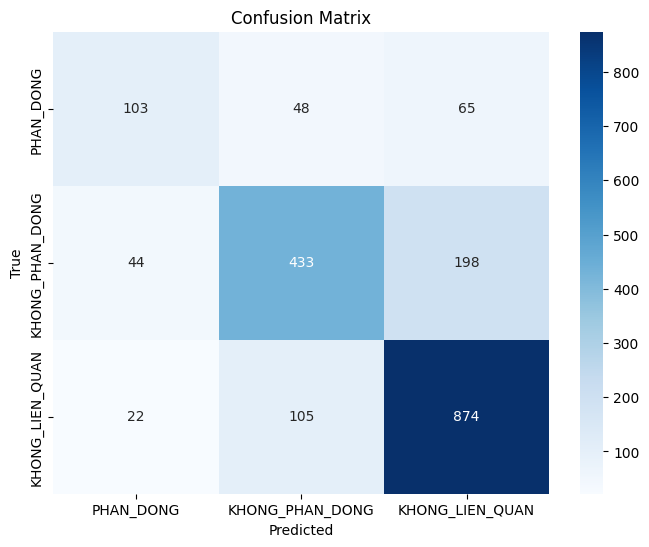


Script finished.


In [ ]:
# --- 8. Evaluation on Test Set  ---
if test_dataset and trainer:
    print("\nEvaluating on the test set...")
    results = trainer.evaluate(test_dataset) # This provides eval_loss, eval_accuracy etc. using compute_metrics
    print("Test set evaluation results (from trainer.evaluate):")
    for key, value in results.items():
        print(f"  {key}: {value:.4f}") # Format output

    print("\nGetting predictions for detailed classification report on the test set...")
    predictions_output = trainer.predict(test_dataset)

    predicted_indices = predictions_output.predictions.argmax(-1) # Get the index of the highest logit
    # Convert numerical predictions back to string labels using the ID_TO_LABEL map
    predicted_labels_text = [ID_TO_LABEL[idx] for idx in predicted_indices]

    # Get true string labels from your test data (e.g., from test_labels_str Series)
    true_labels_text = test_labels_str.tolist()

    print("\nClassification Report on Test Set (Corrected Order):")
    # Add the 'labels' parameter to ensure the report order matches target_names
    print(classification_report(
        true_labels_text,
        predicted_labels_text,
        labels=LABELS,
        target_names=LABELS,
        digits=4
    ))
else:
    print("Cannot evaluate on test set: Test dataset is empty or trainer was not initialized.")

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(true_labels_text, predicted_labels_text, labels=LABELS)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
print("\nScript finished.")

In [ ]:
# !pip install -U nbconvert ipywidgets -q
# !jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/PhoBERT.ipynb" --output-dir="/content/drive/MyDrive/Data/splits/PhoBERT/"
